<font size=12>Application of NDVI Thresholding on Satellite Imagery</font>

Problem: How to identify over a massive area temporary floodplain and seasonal wetland habitat possibly used by salmonids, without using biologists to manually survey the area and without manually labelling thousands of satellite images for habitat classes?

Technical Problem: How to create, validate, and deploy a scalable floodplain/wetland delineation system/tool that requires high resolution data in space and time using remote sensing (satellite imagery) and machine/deep learning?
    
Possible Solutions:  
1. Choose a different problem (genuinely, is this a problem that needs to be solved? has the problem been framed optimally?) 
2. Image Thresholding (traditional literature method -> prone to errors)  
3. Unsupervised Machine Learning (clustering -> unstable, limited reproducibility)  
4. Deep Learning (hype train -> significant hyperparameter optimization -> requires large labelled datasets)  
5. 42 (classical joke as the answer to life)

As you may have guessed, we will choose option 2 to continue exploring Image Thresholding.

In [1]:
import numpy as np
import rasterio
import matplotlib
import matplotlib.pyplot as plt
import skimage
from skimage.filters import (try_all_threshold, threshold_niblack, threshold_sauvola,
                             threshold_mean, threshold_li, threshold_yen, threshold_isodata,
                             threshold_minimum, threshold_triangle, threshold_otsu)

In [2]:
# NDVI is a remote sensing index or derived band from other bands that is particularly good at detecting vegetation (trees/fields)
def gen_NDVI(image_path):
    with rasterio.open(image_path) as ds:
        red_band3 = ds.read(3)
        nir_band4 = ds.read(4)
        np.seterr(divide='ignore', invalid='ignore')
        ndvi_array = ((nir_band4.astype(float) - red_band3.astype(float)) / (nir_band4.astype(float) + red_band3.astype(float)))
        ds.close()
    return ndvi_array 

In [3]:
# load images from data folder
dry_img_path = "./intro_data/reflectance/20161011_final_mosaic.tif"
wet_img_path = "./intro_data/reflectance/20170228_final_mosaic.tif"
ndvi_dry_img = gen_NDVI(dry_img_path)
ndvi_wet_img = gen_NDVI(wet_img_path)
print('The 2D shape of the Dry Image for NDVI on 2016-10-11: {}'.format(ndvi_dry_img.shape))
print('The 2D shape of the Wet Image for NDVI on 2017-02-28: {}'.format(ndvi_wet_img.shape))
print('The shape of the Dry and Wet Image should be equal.')
assert ndvi_dry_img.shape == ndvi_wet_img.shape # what is assert doing?

The 2D shape of the Dry Image for NDVI on 2016-10-11: (1334, 1334)
The 2D shape of the Wet Image for NDVI on 2017-02-28: (1334, 1334)
The shape of the Dry and Wet Image should be equal.


We need to remove "No Data Values". This creates an image for display purposes that maintains the exact shape and creates a modified array for use in histogram analysis. The difference is that the image for display is replacing NaN values as 0, which maintains the array indexing but would effect the data distribution on a histogram, so the histogram array actually removes all the NaN values but changes the array indexing.

In [4]:
# by default nan_to_num is setting No Data Values (NaN) as 0 which should have limited visual impact as NDVI ranges from -1 to 1 (-1 is water, 1 is dense vegetation)
ndvi_dry_img_display = np.nan_to_num(ndvi_dry_img)
ndvi_wet_img_display = np.nan_to_num(ndvi_wet_img)
ndvi_dry_histo = ndvi_dry_img[~np.isnan(ndvi_dry_img)]
ndvi_wet_histo = ndvi_wet_img[~np.isnan(ndvi_wet_img)]
assert ndvi_dry_img_display.shape == ndvi_wet_img_display.shape
total_img_pixels = ndvi_dry_img_display.shape[0]*ndvi_dry_img_display.shape[1]
print('Shape of Images for Display: {} | Total number of pixels: {}'.format(ndvi_dry_img_display.shape, total_img_pixels))
print('Number of non-NaN values in the Dry Histogram Array: {} | Removed {} NaN values'.format(ndvi_dry_histo.shape, total_img_pixels - ndvi_dry_histo.shape[0]))
print('Number of non-NaN values in the Wet Histogram Array: {} | Removed {} NaN values'.format(ndvi_wet_histo.shape, total_img_pixels - ndvi_wet_histo.shape[0]))

Shape of Images for Display: (1334, 1334) | Total number of pixels: 1779556
Number of non-NaN values in the Dry Histogram Array: (1778888,) | Removed 668 NaN values
Number of non-NaN values in the Wet Histogram Array: (1778889,) | Removed 667 NaN values


But where are the NaN values we are removing located in our images?

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


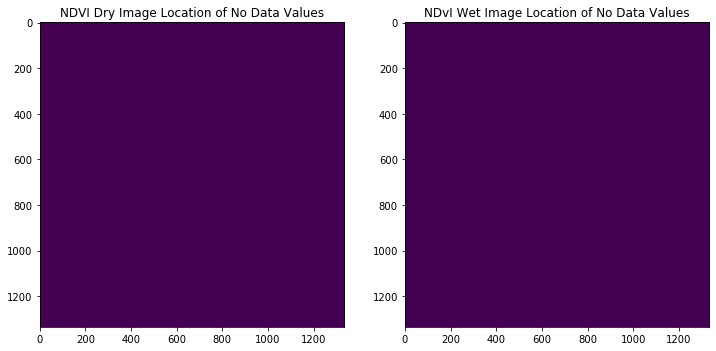

In [5]:
dry_nan = np.where(np.isnan(ndvi_dry_img), 1, 0)
wet_nan = np.where(np.isnan(ndvi_wet_img), 1, 0)
print(dry_nan)
print(wet_nan)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(dry_nan)
plt.title('NDVI Dry Image Location of No Data Values')
plt.subplot(1, 2, 2)
plt.imshow(wet_nan)
plt.title('NDvI Wet Image Location of No Data Values')
plt.show()

Let's visualize our NDVI Images and their respective Histograms.

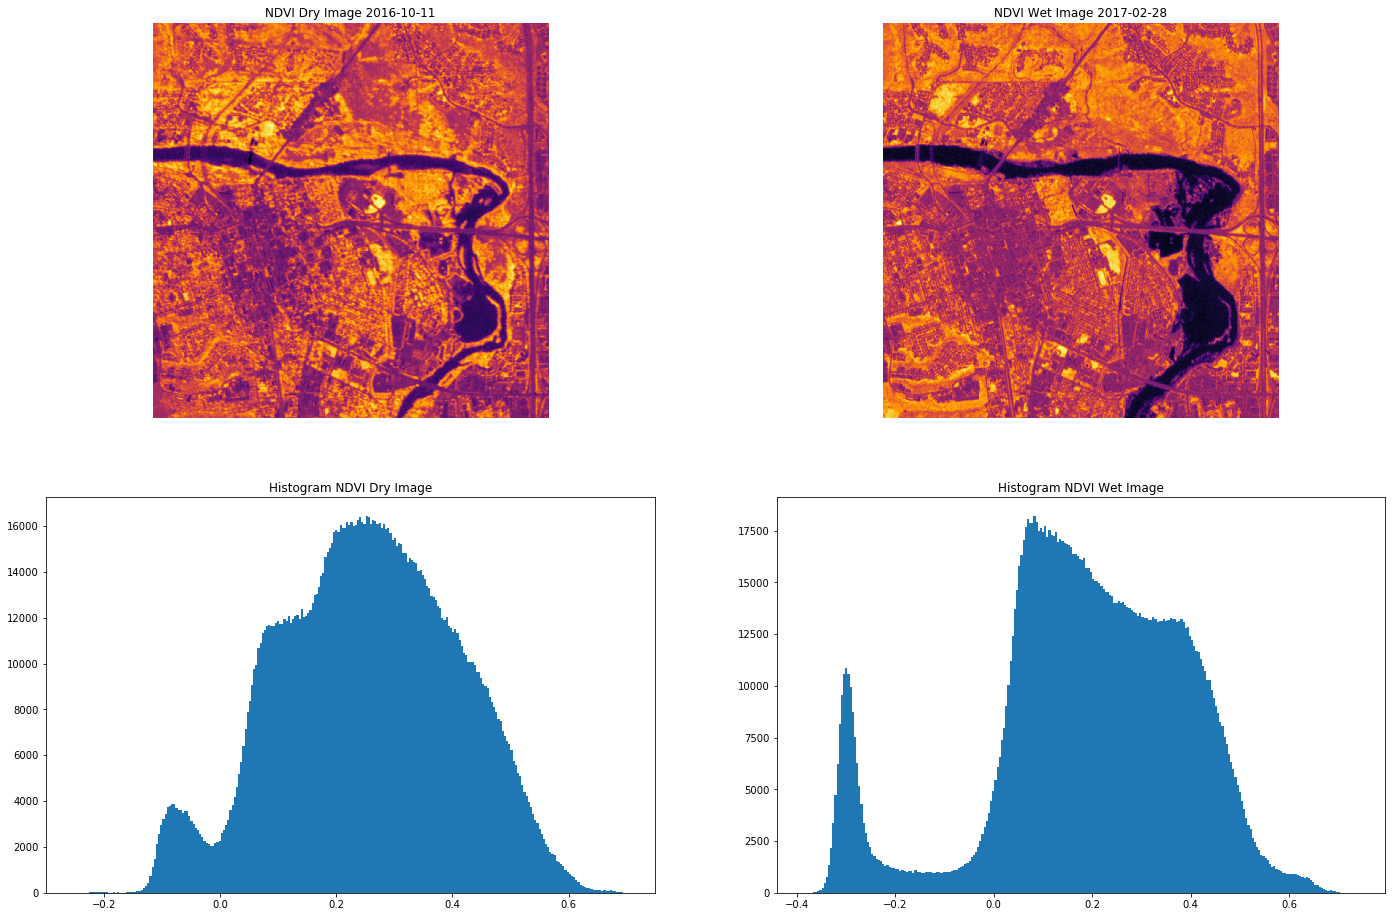

In [6]:
plt.figure(figsize=(24,16))
plt.subplot(2, 2, 1)
plt.imshow(ndvi_dry_img_display, cmap=plt.cm.inferno)
plt.title('NDVI Dry Image 2016-10-11')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(ndvi_wet_img_display, cmap=plt.cm.inferno)
plt.title('NDVI Wet Image 2017-02-28')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.hist(ndvi_dry_histo, bins=256)
plt.title('Histogram NDVI Dry Image')

plt.subplot(2, 2, 4)
plt.hist(ndvi_wet_histo, bins=256)
plt.title('Histogram NDVI Wet Image')
plt.show()

Where do you think the water pixels are located on the histogram?

Let's visualize numerous thresholding methods on our two images.<br>The goal at this point is to try to determine which thresholding method works best in seperating water from not water.<br>(Note: the helper function try_all_threshold requires a 2D array, and thus we give it the 2D image array where NaN's are filled as zeros, this has a very small effect on the result.)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


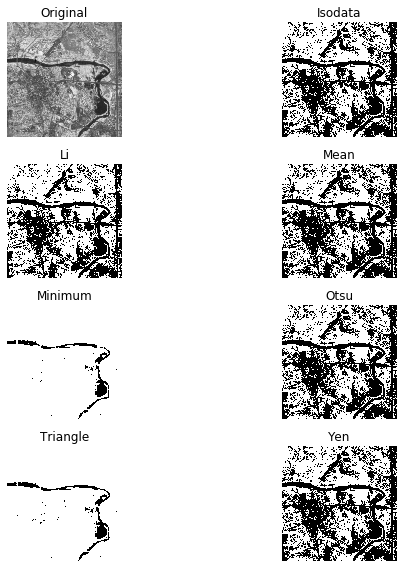

In [7]:
fig, ax = try_all_threshold(ndvi_dry_img_display, figsize=(10,8), verbose=True)
plt.show()

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


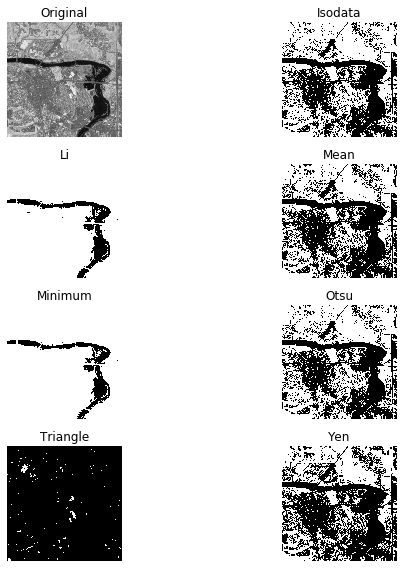

In [8]:
fig, ax = try_all_threshold(ndvi_wet_img_display, figsize=(10,8), verbose=True)
plt.show()

The Minimum technique (threshold_minimum function) is able to accurately separate the water and no water classes from our 1D histogram despite the noisy NaN == 0 inclusion. The other techniques, especially Otsu fail miserably by confusing built-up areas (buildings/roads) with water.<br>(Note: NDVI is usually not used for water seperation but rather field/crop/vegetation separation (i.e. the white areas in the images above).)

In [9]:
# What is the threshold_minimum function actually doing?
# ?? is jupyter magic for display function code and documentation
threshold_minimum??

Signature: threshold_minimum(image, nbins=256, max_iter=10000)
Source:   
def threshold_minimum(image, nbins=256, max_iter=10000):
    """Return threshold value based on minimum method.

    The histogram of the input `image` is computed and smoothed until there are
    only two maxima. Then the minimum in between is the threshold value.

    Parameters
    ----------
    image : (M, N) ndarray
        Input image.
    nbins : int, optional
        Number of bins used to calculate histogram. This value is ignored for
        integer arrays.
    max_iter: int, optional
        Maximum number of iterations to smooth the histogram.

    Returns
    -------
    threshold : float
        Upper threshold value. All pixels with an intensity higher than
        this value are assumed to be foreground.

    Raises
    ------
    RuntimeError
        If unable to find two local maxima in the histogram or if the
        smoothing takes more than 1e4 iterations.

    References
    ----------
    

In [10]:
# How fast and/or scalable is the implemented threshold_minimum function?
# %timeit is a jupyter magic function for determining how fast a function runs
%timeit (threshold_minimum(ndvi_dry_histo))

61.6 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
threshold_dry = threshold_minimum(ndvi_dry_histo)
threshold_wet = threshold_minimum(ndvi_wet_histo)
threshold_dry_otsu = threshold_otsu(ndvi_dry_histo)
threshold_wet_otsu = threshold_otsu(ndvi_wet_histo)
print('Threshold for the Dry Image: {}'.format(threshold_dry))
print('Threshold for the Wet Image: {}'.format(threshold_wet))
ndvi_dry_thresh = ndvi_dry_img_display < threshold_dry
ndvi_wet_thresh = ndvi_wet_img_display < threshold_wet

Threshold for the Dry Image: -0.01907646213388281
Threshold for the Wet Image: -0.12793576931963602


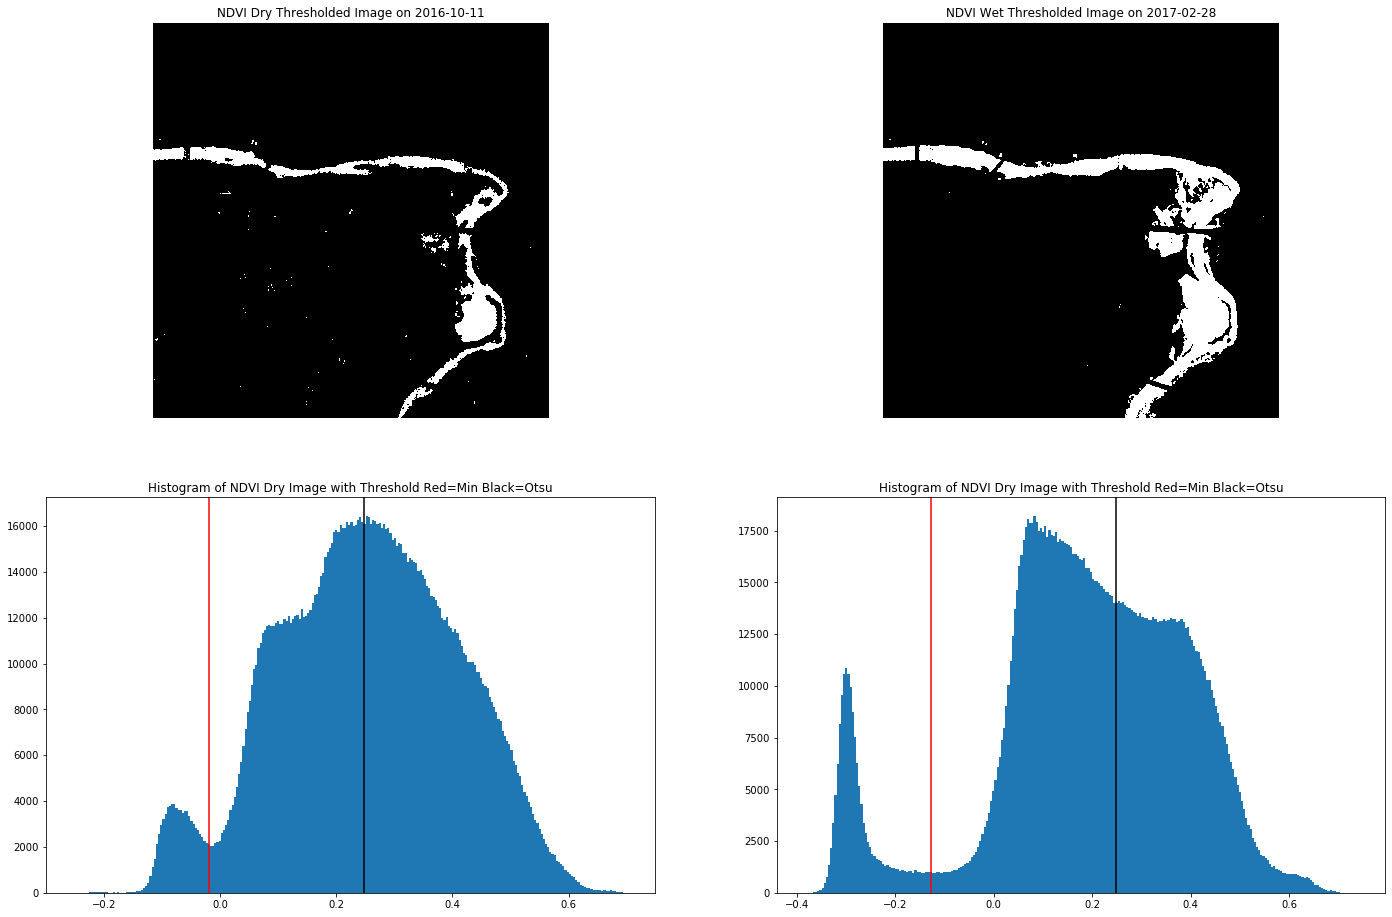

In [12]:
plt.figure(figsize=(24,16))
plt.subplot(2, 2, 1)
plt.imshow(ndvi_dry_thresh, cmap=plt.cm.gray)
plt.title('NDVI Dry Thresholded Image on 2016-10-11')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(ndvi_wet_thresh, cmap=plt.cm.gray)
plt.title('NDVI Wet Thresholded Image on 2017-02-28')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.hist(ndvi_dry_histo, bins=256)
plt.axvline(threshold_dry, color='r')
plt.axvline(threshold_dry_otsu, color='black')
plt.title('Histogram of NDVI Dry Image with Threshold Red=Min Black=Otsu')

plt.subplot(2, 2, 4)
plt.hist(ndvi_wet_histo, bins=256)
plt.axvline(threshold_wet, color='r')
plt.axvline(threshold_dry_otsu, color='black')
plt.title('Histogram of NDVI Dry Image with Threshold Red=Min Black=Otsu')
plt.show()

In [13]:
# ^ is the bitwise boolean operator for subtraction
dry_wet = ndvi_dry_thresh ^ ndvi_wet_thresh
wet_dry = ndvi_wet_thresh ^ ndvi_dry_thresh
assert dry_wet.all() == wet_dry.all()

(-0.5, 1333.5, 1333.5, -0.5)

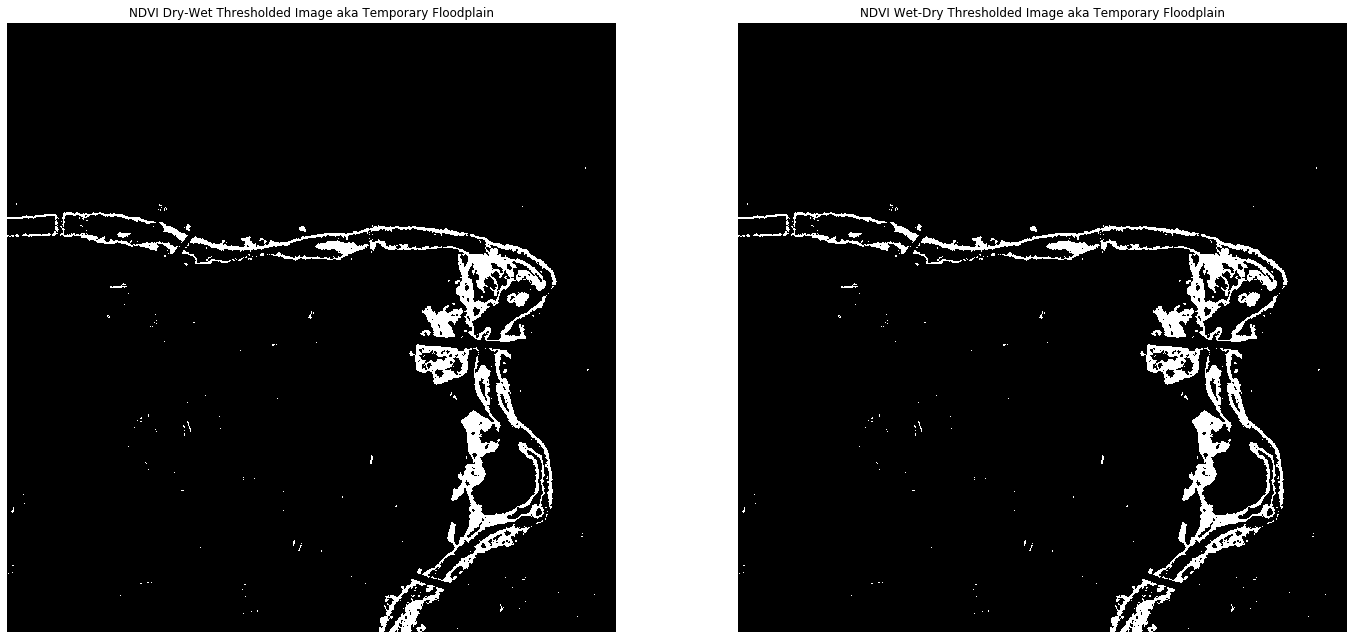

In [14]:
plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(dry_wet, cmap=plt.cm.gray)
plt.title('NDVI Dry-Wet Thresholded Image aka Temporary Floodplain')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wet_dry, cmap=plt.cm.gray)
plt.title('NDVI Wet-Dry Thresholded Image aka Temporary Floodplain')
plt.axis('off')

In [15]:
wd_sum = np.sum(wet_dry)
dw_sum = np.sum(dry_wet)
assert wd_sum == dw_sum
print('Total number of Temporary Floodplain/Seasonal Wetland pixels: ', wd_sum, dw_sum)

Total number of Temporary Floodplain/Seasonal Wetland pixels:  76335 76335


In [16]:
# Each pixel is 3.1 meters x 3.1 meters
pixel_area = 3.1*3.1
total_area_true = dw_sum*pixel_area
print('Area of each pixel in square meters: ', pixel_area)
print('Total area of Temporary Floodplain/Seasonal Wetland in square meters: ', total_area_true)

Area of each pixel in square meters:  9.610000000000001
Total area of Temporary Floodplain/Seasonal Wetland in square meters:  733579.3500000001


In [17]:
# Acres
total_area_true_acres = total_area_true / 4046.856
print('Total area in acres of Temporary Floodplain/Seasonal Wetland detected: ',
      round(total_area_true_acres, 2))

Total area in acres of Temporary Floodplain/Seasonal Wetland detected:  181.27


In [18]:
wet_sum = np.sum(ndvi_wet_thresh)
dry_sum = np.sum(ndvi_dry_thresh)
print('Total number of water pixels: '+'Dry Image: {}'.format(dry_sum)+'     '+'Wet Image: {}'.format(wet_sum))
print('Total area in square meters of water pixels: '+'Dry Image: {}'.format(dry_sum*pixel_area)+'     '+'Wet Image: {}'.format(wet_sum*pixel_area))
print('Total area in acres of of water pixels: '+'Dry Image: {}'.format(round((dry_sum*pixel_area)/4046.856, 2))+ '     ' + 'Wet Image: {}'.format(round((wet_sum*pixel_area)/4046.856, 2)))
print('Total area in acres of target == {} or {} - {} = {}'.format(round(total_area_true_acres, 2), 
                                                                   round((wet_sum*pixel_area)/4046.856, 2), 
                                                                   round((dry_sum*pixel_area)/4046.856, 2), 
                                                                   round((wet_sum*pixel_area)/4046.856, 2)-round((dry_sum*pixel_area)/4046.856, 2)))
print('Small differences likely due to rounding errors')

Total number of water pixels: Dry Image: 81723     Wet Image: 155206
Total area in square meters of water pixels: Dry Image: 785358.0300000001     Wet Image: 1491529.6600000001
Total area in acres of of water pixels: Dry Image: 194.07     Wet Image: 368.57
Total area in acres of target == 181.27 or 368.57 - 194.07 = 174.5
Small differences likely due to rounding errors


[0 1 2]


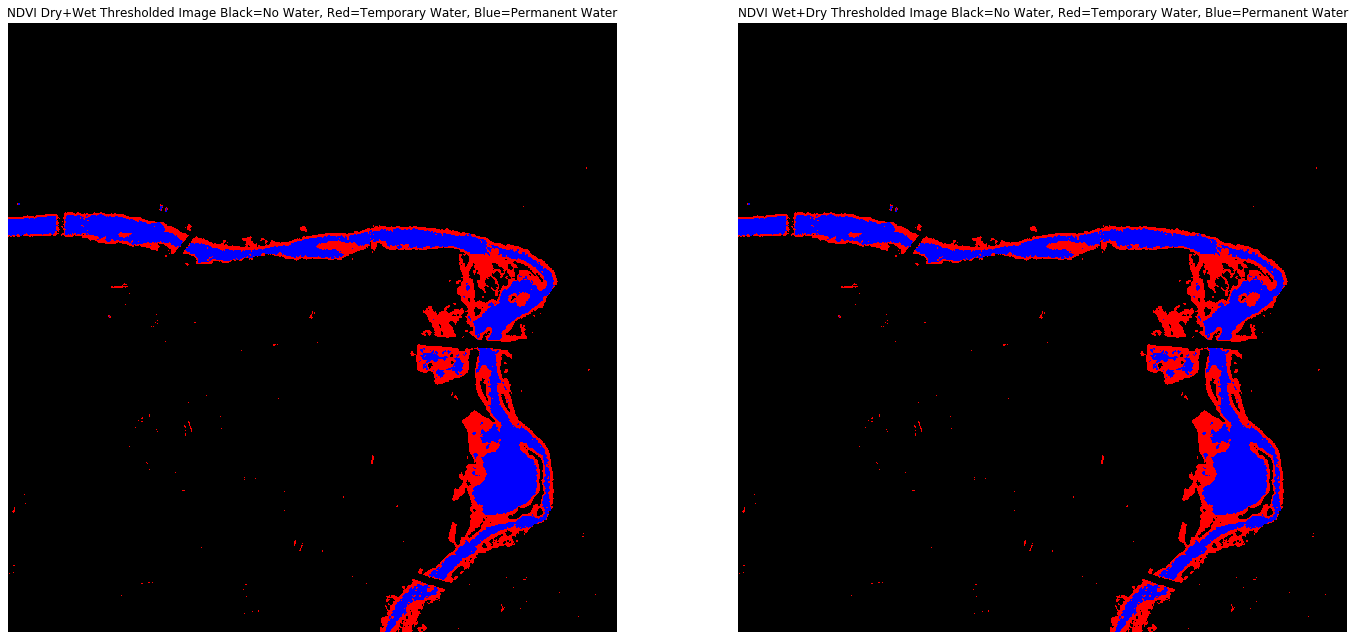

In [19]:
dry_wet_sum = ndvi_dry_thresh.astype(int) + ndvi_wet_thresh.astype(int)
wet_dry_sum = ndvi_wet_thresh.astype(int) + ndvi_dry_thresh.astype(int)
print(np.unique(dry_wet_sum))
Customcmap = matplotlib.colors.ListedColormap(['black', 'red', 'blue'])
plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(dry_wet_sum, cmap=Customcmap)
plt.title('NDVI Dry+Wet Thresholded Image Black=No Water, Red=Temporary Water, Blue=Permanent Water')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wet_dry_sum, cmap=Customcmap)
plt.title('NDVI Wet+Dry Thresholded Image Black=No Water, Red=Temporary Water, Blue=Permanent Water')
plt.axis('off')
plt.show()

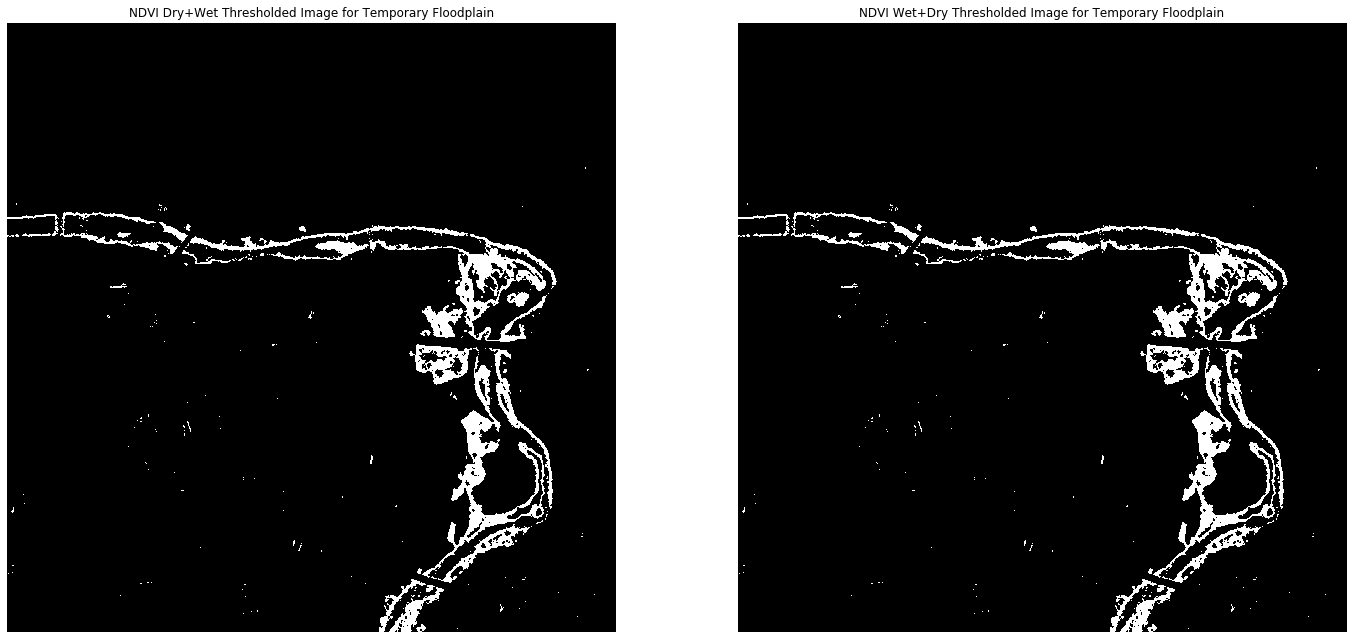

In [20]:
# Why v == 1?
dws = (dry_wet_sum == 1)
wds = (wet_dry_sum == 1)
plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(dws, cmap=plt.cm.gray)
plt.title('NDVI Dry+Wet Thresholded Image for Temporary Floodplain')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wds, cmap=plt.cm.gray)
plt.title('NDVI Wet+Dry Thresholded Image for Temporary Floodplain')
plt.axis('off')
plt.show()

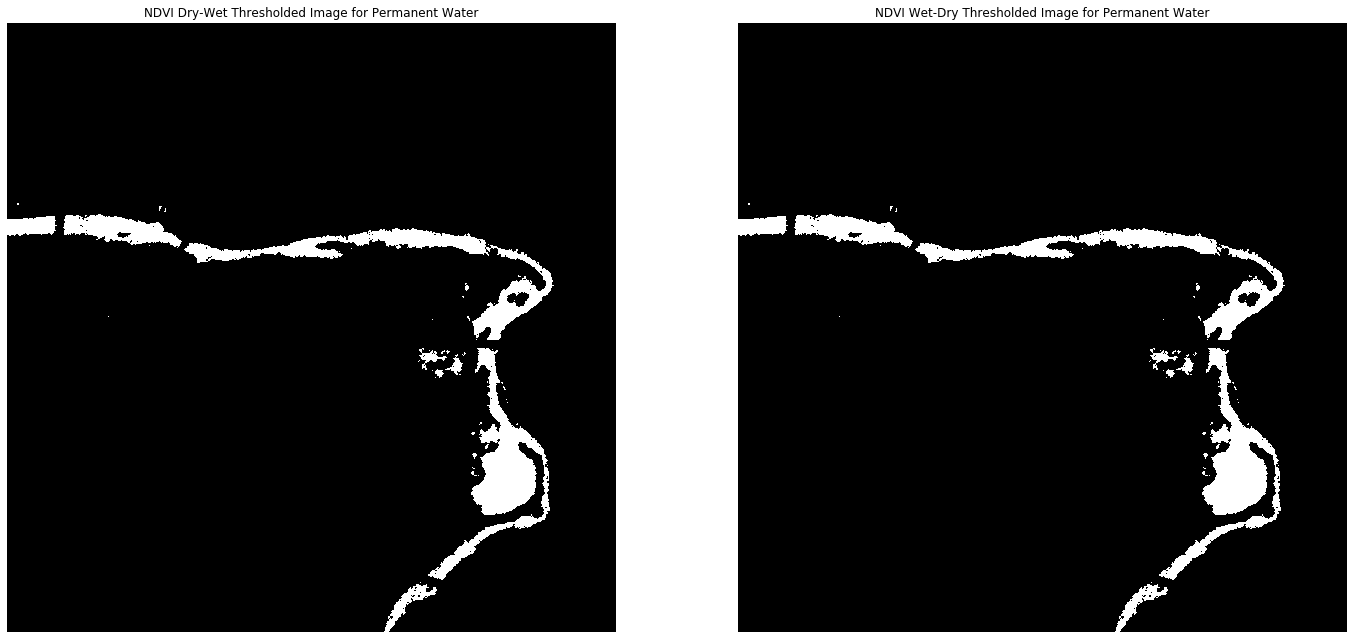

In [21]:
# Why is v == 2?
dws2 = (dry_wet_sum == 2)
wds2 = (wet_dry_sum == 2)
Customcmap = matplotlib.colors.ListedColormap(['black', 'white'])
plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(dws2, cmap=Customcmap)
plt.title('NDVI Dry-Wet Thresholded Image for Permanent Water')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wds2, cmap=Customcmap)
plt.title('NDVI Wet-Dry Thresholded Image for Permanent Water')
plt.axis('off')
plt.show()